In [1]:
import cirq

### The circuit

In [21]:
a, b = cirq.LineQubit.range(2)

qc = cirq.Circuit(
    cirq.H.on(a),
    cirq.CNOT.on(a, b)
)

print(qc)

0: ───H───@───
          │
1: ───────X───


In [22]:
from mitiq.zne.scaling import fold_global
"""We are folding the circuit with scale factor 5"""
# Fold the circuit
folded = fold_global(qc, scale_factor=5.)

In [23]:
import numpy as np
from cirq import Circuit, depolarize, DensityMatrixSimulator

SIMULATOR = DensityMatrixSimulator()

def noiseless(circ: Circuit) -> float:
    """Executes a circuit with no noise and
   returns the expectation value of the obs ZZ."""
    rho = SIMULATOR.simulate(circ).final_density_matrix
    obs = np.diag([1, -1, -1, 1])
    expectation = np.real(np.trace(rho @ obs))
    return expectation

exact = noiseless(qc)
print('Noiseless value without any fold:',exact)

Noiseless value without any fold: 0.9999999403953552


In [24]:
# 5% depolarizing noise
NOISE = 0.05

def noisy(circ: Circuit) -> float:
   """Executes a circuit with depolarizing noise and
   returns the expectation value of the obs ZZ."""
   circuit = circ.with_noise(depolarize(p=NOISE))
   rho = SIMULATOR.simulate(circuit).final_density_matrix
   obs = np.diag([1, -1, -1, 1])
   expectation = np.real(np.trace(rho @ obs))
   return expectation

In [25]:
expval = noisy(folded)
print(f"The ideal result should be {exact}")
print(f"The real result is {expval:.4f}")
print(f"The abslute error is {abs(exact - expval):.4f}")

The ideal result should be 0.9999999403953552
The real result is 0.4078
The abslute error is 0.5922


In [26]:
from mitiq.zne.inference import LinearFactory, RichardsonFactory, PolyFactory


In [27]:
from mitiq.zne.zne import execute_with_zne

scale_factors=[1.0]
error_with_linear = []
error_with_richardson = []
error_with_poly = []
error_real_result = round(abs(exact - expval),4)

for i in range(2,10):
    scale_factors.append(1.0 * i)
    
    # method 1: scale noise by linearly to the zero noise limit.
    linear_fac = LinearFactory(scale_factors=scale_factors)
    zne_expval_linear = execute_with_zne(folded, noisy, factory=linear_fac)
    error_with_linear.append(round(abs(exact - zne_expval_linear),4))


    # method 2: scale noise by the Richardson extrapolation.
    richardson_fac = RichardsonFactory(scale_factors=scale_factors)
    zne_expval_richard = execute_with_zne(folded, noisy, factory=richardson_fac)
    error_with_richardson.append(round(abs(exact - zne_expval_richard),4))
    
#     # method 3: scale noise by quadratically to the zero noise limit.
#     poly_fac = PolyFactory(scale_factors=scale_factors, order=2)
#     zne_expval_poly = execute_with_zne(folded, noisy, factory=poly_fac)
#     error_with_poly.append(round(abs(exact - zne_expval_poly),4))    




In [28]:
import matplotlib.pyplot as plt

In [29]:
print(len(error_with_richardson))
print(len(error_with_linear))
print(len(scale_factors))

8
8
9


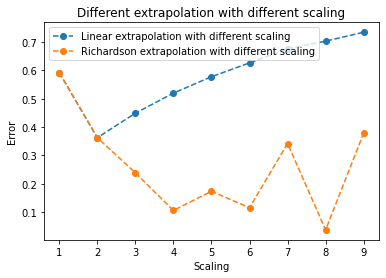

In [30]:
error_with_richardson.insert(0, error_real_result)
error_with_linear.insert(0, error_real_result)


x1 = scale_factors
y1 = error_with_linear
# plotting the line 1 points
plt.plot(x1, y1, "--o", label = "Linear extrapolation with different scaling")

x2 = scale_factors
y2 = error_with_richardson
# plotting the line 1 points
plt.plot(x2, y2, "--o",label = "Richardson extrapolation with different scaling")

# naming the x axis
plt.xlabel('Scaling')
# naming the y axis
plt.ylabel('Error')
# giving a title to my graph
plt.title('Different extrapolation with different scaling')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()
